In [12]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def neg_loglikelihood(p,series,decay=1.,return_jac=True):
    a0=p[0]
    a1=p[1]
    b1=p[2]
    l=0.
    da0 = da1 = db1 = 0
    deriv=np.asarray([0.,0.,0.])
    prev_e = 0
    prev_sigma2 = 0
    for e in series:
        sigma2 = a0 + a1*prev_e*prev_e + b1*prev_sigma2
        l *= decay
        deriv *= decay
        if not np.isnan(e):
            if prev_sigma2>0:
                l += 1.8378770664 + np.log(sigma2) + e*e/sigma2
                da0 = 1 + b1*da0
                da1 = prev_e*prev_e + b1*da1
                db1 = prev_sigma2 + b1*db1
                deriv[0] += da0/sigma2 * (1-e*e/sigma2)
                deriv[1] += da1/sigma2 * (1-e*e/sigma2)
                deriv[2] += db1/sigma2 * (1-e*e/sigma2)
            prev_e = e
            prev_sigma2 = sigma2
        else:
            prev_e = 0
            prev_sigma2 = 0
    if return_jac: return l/len(series)/20, deriv/len(series)/20
    else: return l/2

In [14]:
from arch import arch_model
am = arch_model(None)
sim_data = am.simulate([0.0, 0.11, 0.22, 0.33], 999)
am = arch_model(sim_data['data'])
f=am.fit(update_freq=0,disp='off')
print f
print neg_loglikelihood([f.params[1],f.params[2],f.params[3]],sim_data['data'].values)
print minimize(neg_loglikelihood,[0.2,.3,.4],args=(sim_data['data'].values,),jac=True,method='SLSQP',
               bounds=((0,1),(0,1),(0,1)))
from statsmodels.tools.numdiff import approx_fprime, approx_hess
hess = approx_hess(f.params[1:4], neg_loglikelihood,kwargs={'series':sim_data['data'].values,'return_jac':False})
print np.sqrt(np.diag(np.linalg.inv(hess)))
print np.sqrt(1./np.diag(hess))

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   data   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -668.967
Distribution:                  Normal   AIC:                           1345.93
Method:            Maximum Likelihood   BIC:                           1365.56
                                        No. Observations:                  999
Date:                Sun, Mar 11 2018   Df Residuals:                      995
Time:                        19:47:42   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0101  1.408e-02     -0.717      0.473 

In [15]:
def simulate(p,series,n=0):
    a0,a1,b1 = p
    sigma2v = []
    prev_e = 0
    prev_sigma2 = 0
    for e in series:
        sigma2 = a0 + a1*prev_e*prev_e + b1*prev_sigma2
        sigma2v.append(sigma2)
        if not np.isnan(e):
            prev_e = e
            prev_sigma2 = sigma2
        else:
            prev_e = 0
            prev_sigma2 = 0
    for _ in range(n):
        sigma2 = a0 + a1*prev_e*prev_e + b1*prev_sigma2
        e = np.random.normal(0,np.sqrt(sigma2))
        sigma2v.append(sigma2)
        prev_e = e
        prev_sigma2 = sigma2
    return np.asarray(np.sqrt(sigma2v))

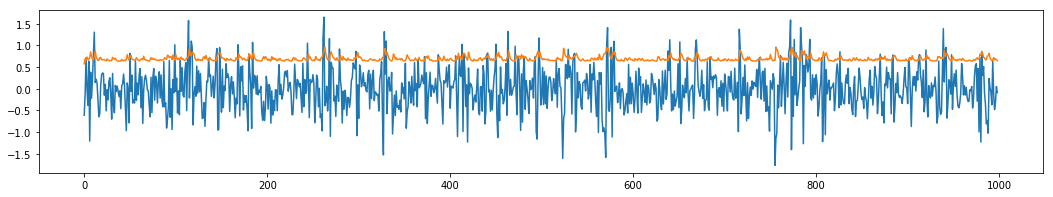

In [16]:
s2=simulate([.11,.22,.33],sim_data['data'].values)
plt.figure(1,figsize=(18,3))
plt.plot(np.arange(s2.shape[0]),sim_data['data'].values,
         np.arange(s2.shape[0]),np.sqrt(s2))